In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from PIL import Image
import matplotlib
from sklearn.model_selection import StratifiedKFold
import keras
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, TensorBoard
from keras import optimizers
from keras.models import Model
from keras.layers import Input, Dropout, UpSampling2D, BatchNormalization, Activation, Dense, Lambda, TimeDistributed, Flatten
from keras.layers import LSTM, GRU, RNN, Reshape, CuDNNGRU, CuDNNLSTM
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, MaxPooling3D
from keras.layers.merge import concatenate
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.optimizers import Adam
from keras.callbacks import Callback
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import gc
import torch
from torch.utils.data import Dataset, DataLoader
from keras import layers, models, applications
from keras.layers import concatenate
from matplotlib import pyplot as plt
import tensorflow as tf
from torch.utils.data import Dataset, DataLoader
from keras import layers, models, applications
import albumentations
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, ToFloat,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, 
    IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose, RandomGamma, ElasticTransform, ChannelShuffle,RGBShift, Rotate
)

from keras.backend.tensorflow_backend import set_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import get_session
import tensorflow
# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()
    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

def random_everything(seed=42):
  os.environ['PYTHONHASHSEED'] = str(42)
  random.seed(42)
  np.random.seed(42)
  tf.set_random_seed(42)

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def f2_m(y_true, y_pred, beta=2):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return (1+beta**2) * (precision*recall) / ((beta**2)*(precision)+recall+K.epsilon())

'''
a = []
while(1):
  a.append('1')
'''

Using TensorFlow backend.


"\na = []\nwhile(1):\n  a.append('1')\n"

In [2]:
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def generate_sector(imgs, labs, idx=0):
  assert idx <= 24
  alphabets = "ABCDEFGHIJKLMNOPQRSTUVW"
  name = alphabets[idx]
  row_idx = idx//5
  col_idx = idx%5
  return imgs[:108, row_idx*200:(row_idx+1)*200, col_idx*200:(col_idx+1)*200, :], labs[:, row_idx*200:(row_idx+1)*200, col_idx*200:(col_idx+1)*200, :]

def calculate_burnt_ratio(labs):
  ratio = np.zeros((labs.shape[0],))
  for i in range(len(labs)):
    ratio[i] = labs[i,:,:,:].mean()
  return ratio

def generate_sectos_combined(imgs, labs, indices=np.arange(20)):
  combined_imgs, combined_labs = generate_sector(imgs, labs, indices[0])
  for idx in range(1, len(indices)):
    sector_imgs, sector_labs = generate_sector(imgs, labs, idx)
    combined_imgs = np.concatenate([combined_imgs, sector_imgs], 0)
    combined_labs = np.concatenate([combined_labs, sector_labs], 0)
  combined_area = calculate_burnt_ratio(combined_labs)
  return combined_imgs, combined_area

def binarize(y, thres=0.05):
  return (y>thres).astype(int)

def dissect_data(imgs, labs, size=108):
  idx = np.array([i for i in range(len(imgs)) if i%size not in [size-2, size-1, size]])
  imgs_0 = imgs[idx, :,:,:]
  imgs_1 = imgs[idx+1, :,:,:]
  imgs_2 = imgs[idx+2, :,:,:]
  labs   = binarize(labs[idx+2])
  return imgs_0, imgs_1, imgs_2, labs
  

In [0]:
water_mask = np.load('/content/gdrive/My Drive/water_mask_based_on_ndvi_565.npy')
water_mask = np.expand_dims(water_mask, 2)

In [5]:
I = 2
trn_idx = [i for i in range(25) if i not in range(5*I, 5*I+5)]
val_idx = [i for i in range(25) if i in range(5*I, 5*I+5)]

imgs = np.load('/content/gdrive/My Drive/cloud_control_data.npz')['imgs']
dnbr = np.load('/content/gdrive/My Drive/cloud_control_data.npz')['dnbr']
labs = (dnbr>0.66).astype(int)
del dnbr
gc.collect()
### apply water mask
for i in range(len(labs)):
  labs[i,:][water_mask==1] = 0

x_trn, y_trn = generate_sectos_combined(imgs, labs, indices=trn_idx)
del imgs, labs
gc.collect()
## normalize
x_trn = x_trn.astype('float32')
x_trn = x_trn / x_trn.max()

x_trn_0, x_trn_1, x_trn_2, y_trn = dissect_data(x_trn, y_trn)
del x_trn
gc.collect()


0

In [6]:
imgs = np.load('/content/gdrive/My Drive/cloud_control_data.npz')['imgs']
dnbr = np.load('/content/gdrive/My Drive/cloud_control_data.npz')['dnbr']
labs = (dnbr>0.66).astype(int)
del dnbr
gc.collect()
### apply water mask
for i in range(len(labs)):
  labs[i,:][water_mask==1] = 0

x_val, y_val = generate_sectos_combined(imgs, labs, indices=val_idx)
del imgs, labs
gc.collect()
## normalize
x_val = x_val.astype('float32')
x_val = x_val / x_val.max()

x_val_0, x_val_1, x_val_2, y_val = dissect_data(x_val, y_val)
del x_val
gc.collect()

del water_mask
gc.collect()

0

In [0]:
gsod = pd.read_csv('/content/gdrive/My Drive/flinders_chase_clean_5day.csv').values
gsod = np.array(gsod, dtype='float')
## normalize
gsod = gsod/gsod.max(axis=0)

num_trn_0, num_trn_1, num_trn_2 = gsod[:-2,:], gsod[1:-1,:], gsod[2:,:10]
num_val_0, num_val_1, num_val_2 = gsod[:-2,:], gsod[1:-1,:], gsod[2:,:10]
for i in range(len(trn_idx)-1):
  num_trn_0 = np.concatenate([num_trn_0, gsod[:-2,:]])
  num_trn_1 = np.concatenate([num_trn_1, gsod[1:-1,:]])
  ### the last series should only have day_0 data!
  num_trn_2 = np.concatenate([num_trn_2, gsod[2:,:10]])
for i in range(len(val_idx)-1):
  num_val_0 = np.concatenate([num_val_0, gsod[:-2,:]])
  num_val_1 = np.concatenate([num_val_1, gsod[1:-1,:]])
  ### the last series should only have day_0 data!
  num_val_2 = np.concatenate([num_val_2, gsod[2:,:10]])

In [0]:
trn_adjacency = pd.read_csv('/content/gdrive/My Drive/trn_adjacency.csv')
val_adjacency = pd.read_csv('/content/gdrive/My Drive/val_adjacency.csv')
sub_columns = [i for i in trn_adjacency.columns if i.startswith(f"f_{I}")]
trn_adjacency = trn_adjacency[sub_columns]
val_adjacency = val_adjacency[sub_columns]

## normalize
MAX = pd.concat([trn_adjacency, val_adjacency], 0).max()
trn_adjacency = trn_adjacency/MAX
val_adjacency = val_adjacency/MAX

s = 0
adj_trn_0 = trn_adjacency[[f'f_{I}_s_{s}_d_south', f'f_{I}_s_{s}_d_north',f'f_{I}_s_{s}_d_west',f'f_{I}_s_{s}_d_east', f'f_{I}_s_{s}_d_southwest', f'f_{I}_s_{s}_d_northwest',f'f_{I}_s_{s}_d_southeast',f'f_{I}_s_{s}_d_northeast']]
s = 1
adj_trn_1 = trn_adjacency[[f'f_{I}_s_{s}_d_south', f'f_{I}_s_{s}_d_north',f'f_{I}_s_{s}_d_west',f'f_{I}_s_{s}_d_east', f'f_{I}_s_{s}_d_southwest', f'f_{I}_s_{s}_d_northwest',f'f_{I}_s_{s}_d_southeast',f'f_{I}_s_{s}_d_northeast']]
s = 2
adj_trn_2 = trn_adjacency[[f'f_{I}_s_{s}_d_south', f'f_{I}_s_{s}_d_north',f'f_{I}_s_{s}_d_west',f'f_{I}_s_{s}_d_east', f'f_{I}_s_{s}_d_southwest', f'f_{I}_s_{s}_d_northwest',f'f_{I}_s_{s}_d_southeast',f'f_{I}_s_{s}_d_northeast']]

s = 0
adj_val_0 = val_adjacency[[f'f_{I}_s_{s}_d_south', f'f_{I}_s_{s}_d_north',f'f_{I}_s_{s}_d_west',f'f_{I}_s_{s}_d_east', f'f_{I}_s_{s}_d_southwest', f'f_{I}_s_{s}_d_northwest',f'f_{I}_s_{s}_d_southeast',f'f_{I}_s_{s}_d_northeast']]
s = 1
adj_val_1 = val_adjacency[[f'f_{I}_s_{s}_d_south', f'f_{I}_s_{s}_d_north',f'f_{I}_s_{s}_d_west',f'f_{I}_s_{s}_d_east', f'f_{I}_s_{s}_d_southwest', f'f_{I}_s_{s}_d_northwest',f'f_{I}_s_{s}_d_southeast',f'f_{I}_s_{s}_d_northeast']]
s = 2
adj_val_2 = val_adjacency[[f'f_{I}_s_{s}_d_south', f'f_{I}_s_{s}_d_north',f'f_{I}_s_{s}_d_west',f'f_{I}_s_{s}_d_east', f'f_{I}_s_{s}_d_southwest', f'f_{I}_s_{s}_d_northwest',f'f_{I}_s_{s}_d_southeast',f'f_{I}_s_{s}_d_northeast']]


In [0]:
def ConvBlock(inputs, suffix=0, prefix="cnn"):
    """no final linear dense layer!"""
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_1a")(inputs)
    conv1 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_1a")(conv1)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_1b")(conv1)
    conv1 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_1b")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name=f"{prefix}_{suffix}_maxpool_1")(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_2a")(pool1)
    conv2 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_2a")(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_2b")(conv2)
    conv2 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_2b")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name=f"index_{suffix}_maxpool_2")(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_3a")(pool2)
    conv3 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_3a")(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_3b")(conv3)
    conv3 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_3b")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name=f"index_{suffix}_maxpool_3")(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_4a")(pool3)
    conv4 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_4a")(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', name=f"{prefix}_{suffix}_conv_4b")(conv4)
    conv4 = BatchNormalization(name=f"{prefix}_{suffix}_batchnorm_4b")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name=f"{prefix}_{suffix}_maxpool_4")(conv4)    
    
    flatten= Flatten(name=f"{prefix}_{suffix}_flatten")(pool4)
    dense1 = Dense(64, activation="relu", name=f"{prefix}_{suffix}_relu_1")(flatten)
    drop1  = Dropout(0.4, name=f"{prefix}_{suffix}_drop_1")(dense1)
    dense2 = Dense(32, activation="relu", name=f"{prefix}_{suffix}_relu_2")(drop1)
    drop2  = Dropout(0.3, name=f"{prefix}_{suffix}_drop_2")(dense2)
    dense3 = Dense(16, activation="relu", name=f"{prefix}_{suffix}_relu_3")(drop2)
    drop3  = Dropout(0.2, name=f"{prefix}_{suffix}_drop_3")(dense3)
    dense4 = Dense(8, activation="relu",  name=f"{prefix}_{suffix}_relu_4")(drop3)
    #dense4 = Dense(1, activation="linear", name=f"{prefix}_{suffix}_linear")(drop3)
    return dense4

def MLP(inputs, suffix=0, prefix='mlp'):
    dense = Dense(8, activation='relu', name=f"{prefix}_{suffix}_relu_1")(inputs)
    dense = Dense(4, activation='relu', name=f"{prefix}_{suffix}_relu_2")(dense)
    #dense = Dense(1, activation='linear', name=f"{prefix}_{suffix}_linear")(dense)
    return dense
    

In [3]:
n_channels = 14
sector_dim = 200

img_0 = Input((sector_dim,sector_dim,n_channels), name="cnn_input_0")
img_1 = Input((sector_dim,sector_dim,n_channels), name="cnn_input_1")
img_2 = Input((sector_dim,sector_dim,n_channels), name="cnn_input_2")

num_0 = Input((50,), name="gsod_input_0")
num_1 = Input((50,), name="gsod_input_1")
num_2 = Input((10,), name="gsod_input_2")

adj_0 = Input((8,), name="adj_input_0")
adj_1 = Input((8,), name="adj_input_1")
adj_2 = Input((8,), name="adj_input_2")

cnn_0 = ConvBlock(img_0, suffix=0)
cnn_1 = ConvBlock(img_1, suffix=1)
cnn_2 = ConvBlock(img_2, suffix=2)

num_0_m = MLP(num_0, suffix=0, prefix="gsod")
num_1_m = MLP(num_1, suffix=1, prefix="gsod")
num_2_m = MLP(num_2, suffix=2, prefix="gsod")

adj_0_m = MLP(adj_0, suffix=0, prefix="adj")
adj_1_m = MLP(adj_1, suffix=1, prefix="adj")
adj_2_m = MLP(adj_2, suffix=2, prefix="adj")

mixed_0 = concatenate([cnn_0, num_0_m, adj_0_m], name='mixed_0')
mixed_1 = concatenate([cnn_1, num_1_m, adj_1_m], name='mixed_1')
mixed_2 = concatenate([cnn_2, num_2_m, adj_2_m], name='mixed_2')

concat   = concatenate([mixed_0, mixed_1, mixed_2], name="concat_mixed")
reshape    = Reshape((3, -1), name="reshape")(concat)
lstm       = CuDNNLSTM(256, name='lstm_1', return_sequences=True)(reshape)
lstm       = Dropout(0.4, name='lstm_drop_1')(lstm)
lstm       = CuDNNLSTM(256, name='lstm_2')(lstm)
lstm       = Dropout(0.4, name='lstm_drop_2')(lstm)
dense      = Dense(10, activation="relu", name="fc_relu")(lstm)
dense      = Dense(1, activation="sigmoid", name="fc_sigmoid")(dense)

model = Model(inputs=[img_0, img_1, img_2, num_0, num_1, num_2, adj_0, adj_1, adj_2], output=dense)
model.summary()














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input_0 (InputLayer)        (None, 200, 200, 14) 0                                            
__________________________________________________________________________________________________
cnn_input_1 (InputLayer)        (None, 200, 200, 14) 0                                            
__________________________________________________________________________________________________
cnn_input_2 (InputLayer)        (None, 200, 200, 14) 0                                            
__________________________________________________________________________________________________
cnn_0_conv_1a (Conv2D)          (None, 200, 200, 64) 8128      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("fc...)`


In [0]:
def custom_loss(y_true, y_pred):
  crossentropy_loss = K.binary_crossentropy(y_true, y_pred)
  weight  = (y_true*9)+1
  return crossentropy_loss*(weight)

In [12]:
random_everything(seed=42)
#model = Model(inputs=[img_0, img_1, img_2, num_0, num_1, num_2, adj_0, adj_1, adj_2], output=dense)

model.compile(optimizer = Adam(lr=1e-4, decay=1e-6), 
              loss=custom_loss,
              metrics=['acc', recall_m, precision_m, f1_m, f2_m])

ckpt = ModelCheckpoint(f"/content/gdrive/My Drive/CNN_LSTM_{I}_adj_watermask_5day.hdf5", monitor = "val_loss", save_best_only = True, mode = "min", save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = model.fit([x_trn_0, x_trn_1, x_trn_2, num_trn_0, num_trn_1, num_trn_2, adj_trn_0, adj_trn_1, adj_trn_2], y_trn,
                        validation_data=([x_val_0, x_val_1, x_val_2, num_val_0, num_val_1, num_val_2, adj_val_0, adj_val_1, adj_val_2], y_val),
                        batch_size=24, epochs=300,
                        callbacks=[es, ckpt, 
                                   keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
                                   ]
                        )



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2120 samples, validate on 530 samples
Epoch 1/300
2120/2120 [==============================] - 73s 34ms/step - loss: 0.9494 - acc: 0.9458 - recall_m: 0.0038 - precision_m: 0.0038 - f1_m: 0.0038 - f2_m: 0.0038 - val_loss: 1.1710 - val_acc: 0.9245 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_f2_m: 0.0000e+00
Epoch 2/300
2120/2120 [==============================] - 56s 26ms/step - loss: 0.9247 - acc: 0.9491 - recall_m: 0.0028 - precision_m: 0.0113 - f1_m: 0.0045 - f2_m: 0.0033 - val_loss: 1.0676 - val_acc: 0.9226 - val_recall_m: 0.0226 - val_precision_m: 0.0453 - val_f1_m: 0.0302 - val_f2_m: 0.0252
Epoch 3/300
2120/2120 [==============================] - 56s 26ms/step - loss: 0.8899 - acc: 0.9382 - recall_m: 0.0547 - precision_m: 0.0547 - f1_m: 0.0498 - f2_m: 0.0516 - val_loss: 1.0427 - val_acc: 0.9075 - val_recall_m: 0.0744 - val_precision_m:

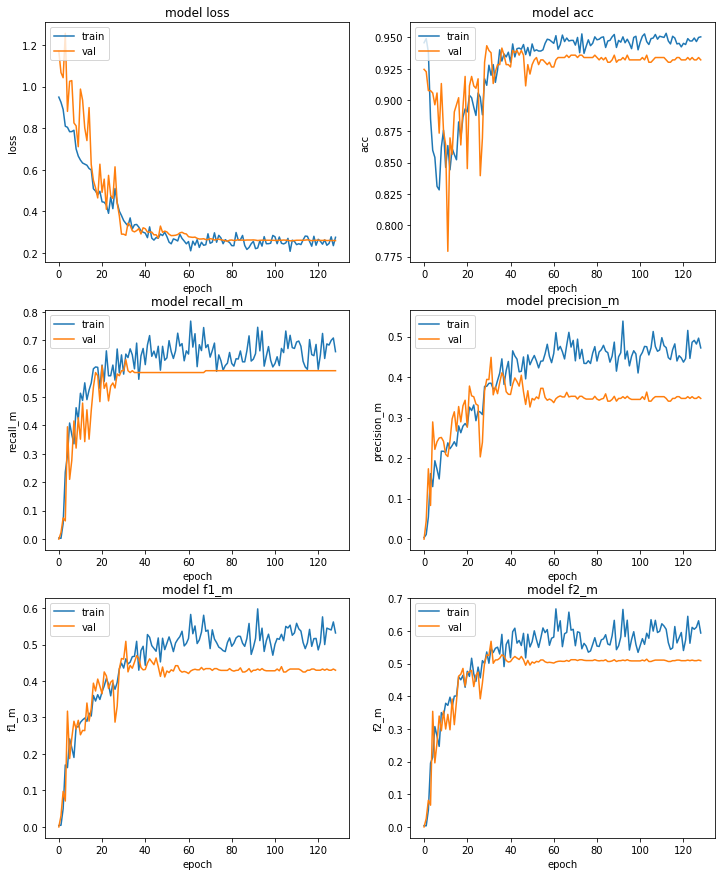

In [13]:
def plot_history(history):
  plt.figure(figsize=(12,15))
  plt.subplot(3,2,1)
  name = 'loss'
  plt.plot(history.history[name])
  plt.plot(history.history[f'val_{name}'])
  plt.title(f'model {name}')
  plt.ylabel(f'{name}')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.subplot(3,2,2)
  name = 'acc'
  plt.plot(history.history[name])
  plt.plot(history.history[f'val_{name}'])
  plt.title(f'model {name}')
  plt.ylabel(f'{name}')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.subplot(3,2,3)
  name = 'recall_m'
  plt.plot(history.history[name])
  plt.plot(history.history[f'val_{name}'])
  plt.title(f'model {name}')
  plt.ylabel(f'{name}')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.subplot(3,2,4)
  name = 'precision_m'
  plt.plot(history.history[name])
  plt.plot(history.history[f'val_{name}'])
  plt.title(f'model {name}')
  plt.ylabel(f'{name}')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.subplot(3,2,5)
  name = 'f1_m'
  plt.plot(history.history[name])
  plt.plot(history.history[f'val_{name}'])
  plt.title(f'model {name}')
  plt.ylabel(f'{name}')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.subplot(3,2,6)
  name = 'f2_m'
  plt.plot(history.history[name])
  plt.plot(history.history[f'val_{name}'])
  plt.title(f'model {name}')
  plt.ylabel(f'{name}')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

plot_history(history)

In [14]:
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, cohen_kappa_score, roc_auc_score, accuracy_score

model.load_weights(f"/content/gdrive/My Drive/CNN_LSTM_{I}_adj_watermask_5day.hdf5")
preds = model.predict([x_val_0, x_val_1, x_val_2, num_val_0, num_val_1, num_val_2, adj_val_0, adj_val_1, adj_val_2])

print(recall_score(y_val, preds.round()))
print(fbeta_score(y_val, preds.round(), 2))
print(f1_score(y_val, preds.round()))
print(cohen_kappa_score(y_val, preds.round().flatten()))
print(roc_auc_score(y_val, preds.round()))
print(accuracy_score(y_val, preds.round()))
print(precision_score(y_val, preds.round()))
np.save(f'/content/gdrive/My Drive/preds_{I}', preds.flatten())


0.975
0.8369098712446352
0.6902654867256637
0.6567992599444958
0.9528061224489798
0.9339622641509434
0.5342465753424658
